In [1]:
import z3
import numpy as np
from functools import cache
from pprint import pprint
%load_ext line_profiler

from importlib import reload
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')
sys.path.append('../model/')

import simulation
import analysis
reload(simulation)
reload(analysis)

<module 'analysis' from '/mnt/c/Users/faust/OneDrive - UvA/research_projects/2024_pLoTRSA/pLOT_RSA/case_studies/../model/analysis.py'>

In [3]:
from Models import ObjectsModel
from QUD import ProductQUD
from analysis import parse, already_defined, analyse_specific_hyps, plot_results
from simulation import infer_meaning, define_grammar

ImportError: cannot import name 'define_grammar' from 'simulation' (/mnt/c/Users/faust/OneDrive - UvA/research_projects/2024_pLoTRSA/pLOT_RSA/case_studies/../model/simulation.py)

Some generally useful stuff that doesn't really change:

In [4]:
n_objects = 5

grammar_phon = define_grammar(
    n_props, 
    False
)

grammar_utt = define_grammar(
    n_props, 
    True
)

grammar_belief = define_grammar(
    n_props=n_props, 
    EXH=False, 
    index=2
)

m = BooleanModel(
    n_props
)

NameError: name 'define_grammar' is not defined

# Pseudo-quantifiers attempt

In [5]:
def trees_seen_by(s):
    """
    Returns a Z3 expression for the number of trees that squirrel s sees.
    """
    return z3.Sum([z3.If(sees(s, t), 1, 0) for t in dom_trees])

def partition_function(i):
    """
    Returns a Z3 expression that encodes the number of squirrels that see exactly i trees.
    
    That is, for a given integer i (0 <= i <= k_trees), partition_function(i) is
    the sum over all squirrels s in dom_squirrels of 1 if trees_seen_by(s) == i, and 0 otherwise.
    """
    return z3.Sum([z3.If(trees_seen_by(s) == i, 1, 0) for s in dom_squirrels])

In [6]:
def Some(domain, predicate):
    """
    Given a list of domain elements and a predicate function (that takes an element and returns a Bool),
    return a Z3 formula that is the disjunction over the domain.
    """
    return z3.Or([predicate(x) for x in domain])

def All(domain, predicate):
    """
    Given a list of domain elements and a predicate function,
    return a Z3 formula that is the conjunction over the domain.
    """
    return z3.And([predicate(x) for x in domain])

// type <et,<et,t>>
some(
    // type <e,t>
    squirrels, 
    // type <e,t>
    run
)


all(
    // 
    squirrels,
    // <t>
    // but the x1 argument of 'all' abstracts it to <e,t>
    some(
        // <e,t>
        trees,
        // <e,t>
        see(x1)
    ),
    x1
)

some(
    trees,
    all(
        squirrels,
        see(x1)(x2),
        x1
    ),
    x2
)

In [30]:
Squirrel = z3.DeclareSort('squirrels')
Tree = z3.DeclareSort('trees')
k_squirrels = 5
k_trees = 5

# list of constants representing the domain elements of types
dom_squirrels = [z3.Const(f's_{i}', Squirrel) for i in range(k_squirrels)] 
dom_trees = [z3.Const(f't_{i}', Tree) for i in range(k_trees)] 

# Define P as a predicate over T.
sees = z3.Function(f'sees', Squirrel, Tree, z3.BoolSort())

In [45]:
solver = z3.Solver()

# example of a formula
formula = Some(dom_trees, lambda t: All(dom_squirrels, lambda s: sees(s, t)))

solver.add(formula)

# Check and print the model:
if solver.check() == z3.sat:
    model = solver.model()
    print(model)
else:
    print("Unsatisfiable")

[s_2 = squirrels!val!2,
 s_1 = squirrels!val!1,
 t_3 = trees!val!3,
 t_1 = trees!val!1,
 s_0 = squirrels!val!0,
 t_4 = trees!val!4,
 t_0 = trees!val!0,
 s_3 = squirrels!val!3,
 t_2 = trees!val!2,
 s_4 = squirrels!val!4,
 sees = [(squirrels!val!0, trees!val!1) -> True,
         (squirrels!val!1, trees!val!1) -> True,
         (squirrels!val!2, trees!val!1) -> True,
         (squirrels!val!3, trees!val!1) -> True,
         (squirrels!val!4, trees!val!1) -> True,
         else -> False]]


Grammar:

S -> Some(DOM, F )
S -> All( DOM, F )

In [9]:
sees(dom_squirrels[0], dom_trees[0])

sees(s_0, t_0)

In [ ]:
# Define an expression counting how many elements satisfy each predicate.
count_Ps = Sum([If(P(x), 1, 0) for x in dom])

# Express "most" as:
# count_P > len(dom)/2  where len(dom) is k.
solver = Solver()
solver.add(count_P > k / 2)

In [10]:
# Declare a generic (uninterpreted) sort A.
A = z3.DeclareSort('A')

# Declare a binary predicate R on A: R: A x A -> Bool.
R = z3.Function('R', A, A, z3.BoolSort())

# Declare variables over A.
x, y, z = z3.Consts('x y z', A)

# Axioms: Assume that R is reflexive and transitive.
reflex_axiom = z3.ForAll(x, R(x, x))
trans_axiom = z3.ForAll([x, y, z], z3.Implies(z3.And(R(x, y), R(y, z)), R(x, z)))

# Our formula:
# For every x, there exists a y such that for every z, if R(x,z) then R(y,z).
formula = z3.ForAll(x, z3.Exists(y, z3.ForAll(z, z3.Implies(R(x, z), R(y, z)))))

# Create a solver and add the axioms and the negation of the formula.
s = z3.Solver()
s.add(reflex_axiom, trans_axiom, z3.Not(formula))

# Check for unsatisfiability.
result = s.check()
print("Solver result:", result)

Solver result: unsat


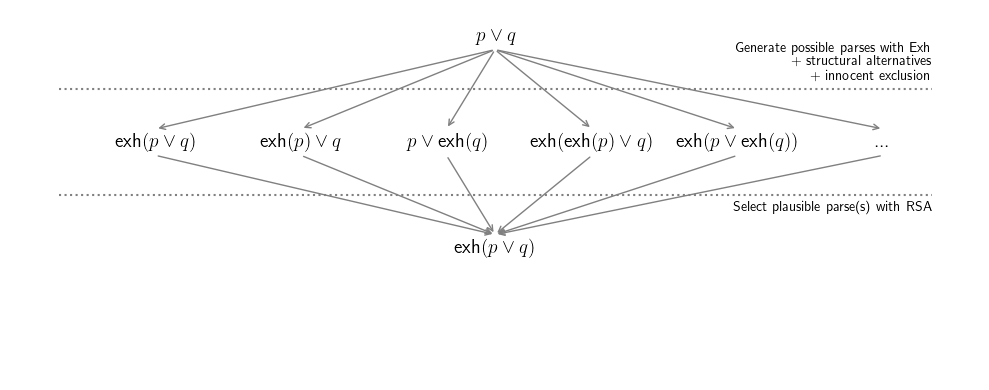

In [123]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 4))

# Set limits and remove axes
ax.set_xlim(0, 10)
ax.set_ylim(0, 1.4)
ax.axis('off')

# Define y-levels for layers
top_y = 1.2
mid_y = 0.8
bottom_y = 0.4

# Draw dotted lines to separate layers
top_dotted = top_y - 0.1
bottom_dotted = mid_y - 0.1
ax.hlines([top_dotted, bottom_dotted], xmin=0.5, xmax=9.5, colors='gray', linestyles='dotted')

# Annotate dotted lines
ax.text(9.5, top_dotted + 0.1, "Generate possible parses with Exh\n+ structural alternatives\n+ innocent exclusion", 
        va='center', ha='right', fontsize=10)
ax.text(9.5, bottom_dotted - 0.05, "Select plausible parse(s) with RSA", 
        va='center', ha='right', fontsize=10)

# Top layer sentence
top_x = 5
ax.text(top_x, top_y + 0.1, r'$p \lor q$', ha='center', va='center', fontsize=14)

# Mid layer sentences
mid_sentences = [
    r'$\text{exh}(p \lor q)$',
    r'$\text{exh}(p) \lor q$',
    r'$p \lor \text{exh}(q)$',
    r'$\text{exh}(\text{exh}(p) \lor q)$',
    r'$\text{exh}(p \lor \text{exh}(q))$',
    r'...'
]
x_positions = [1.5 + 1.5 * i for i in range(len(mid_sentences))]  # spread across the plot

for x, sentence in zip(x_positions, mid_sentences):
    ax.text(x, mid_y + 0.1, sentence, ha='center', va='center', fontsize=14)
    # Arrow from top to mid
    ax.annotate('', xy=(x, mid_y + 0.15), xytext=(top_x, top_y+0.05),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1))

# Bottom layer sentence
bottom_x = 5
ax.text(bottom_x, bottom_y + 0.1, r'$\text{exh}(p \lor q)$', ha='center', va='center', fontsize=14)

# Arrows from mid to bottom
for x in x_positions:
    ax.annotate('', xy=(bottom_x, bottom_y + 0.15), xytext=(x, mid_y+0.05),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1))

plt.tight_layout()
plt.savefig('fig.png', dpi=300)
